In [3]:
##############      Configuración      ##############
from dotenv import dotenv_values
from plantilla import plantilla

path_proyecto   =  "/mnt/r/Tesis Nico/Códigos"    # Ubicación de la carpeta del Proyecto
subproyecto = 'Testing - Deep Learning con MapTilesDownloader'

path_datain     = f"{path_proyecto}/data/data_in"
path_dataout    = f"{path_proyecto}/data/data_out/{subproyecto}"  # Bases procesadas por tus scripts
path_scripts    = f"{path_proyecto}/scripts/{subproyecto}"
path_figures    = f"{path_proyecto}/outputs/figures/{subproyecto}"
path_maps       = f"{path_proyecto}/outputs/maps/{subproyecto}"
path_tables     = f"{path_proyecto}/outputs/tables/{subproyecto}"

In [4]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

# the next 3 lines of code are for my machine and setup due to https://github.com/tensorflow/tensorflow/issues/43174
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-01-25 16:10:12.687400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/oficina825/miniconda3/envs/tf/lib/
2023-01-25 16:10:12.687549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/oficina825/miniconda3/envs/tf/lib/
2023-01-25 16:10:12.687558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [5]:
def visualize_augmentations(data_generator: ImageDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.
    Parameters
    ----------
    data_generator : Iterator
        The keras data generator of your training data.
    df : pd.DataFrame
        The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    for pos in [np.random.randint(0, len(df))]:
        series = df.iloc[pos]

        df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

        iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
            dataframe=df_augmentation_visualization,
            x_col="image",
            y_col="rmax",
            class_mode="raw",
            target_size=(512, 512),  # size of the image
            batch_size=1,  # use only one image for visualization
        )

        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
            batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
            img = batch[0]  # type: ignore
            img = img[0, :, :, :]  # remove one dimension for plotting without issues
            plt.imshow(img)
        
        fig = plt.gcf()
        fig.set_size_inches(18.5, 18.5)

        plt.show()
        plt.close()


def get_mean_baseline(train: pd.DataFrame, val: pd.DataFrame) -> float:
    """Calculates the mean MAE and MAPE baselines by taking the mean values of the training data as prediction for the
    validation target feature.
    Parameters
    ----------
    train : pd.DataFrame
        Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Pandas DataFrame containing your validation data.
    Returns
    -------
    float
        MAPE value.
    """
    y_hat = train["rmax"].mean()
    val["y_hat"] = y_hat
    mae = MeanAbsoluteError()
    mae = mae(val["rmax"], val["y_hat"]).numpy()  # type: ignore
    mape = MeanAbsolutePercentageError()
    mape = mape(val["rmax"], val["y_hat"]).numpy()  # type: ignore

    print(mae)
    print("mean baseline MAPE: ", mape)

    return mape


def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val = train_test_split(df, test_size=0.2, random_state=1)  # split the data with a validation size o 20%
    train, test = train_test_split(
        train, test_size=0.125, random_state=1
    )  # split the data with an overall  test size of 10%

    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore
    print("shape test: ", test.shape)  # type: ignore

    print("Descriptive statistics of train:")
    display(train.describe())  # type: ignore
    return train, val, test  # type: ignore

def random_crop(img, random_crop_size):
    # https://jkjung13.medium.com/extending-keras-imagedatagenerator-to-support-random-cropping-f586b1b7c450
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

def create_generators(
    df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, plot_augmentations: Any
) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.
    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.
    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """
    train_generator = ImageDataGenerator(
        rescale=1.0 / 512,
        width_shift_range=0.075,
        height_shift_range=0.075,
        brightness_range=(0.75,1),
        shear_range=0.075,
        zoom_range=[0.25, 1],
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2,
    )  # create an ImageDataGenerator with multiple image augmentations
    validation_generator = ImageDataGenerator(
        rescale=1.0 / 255
    )  # except for rescaling, no augmentations are needed for validation and testing generators
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    # visualize image augmentations
    if plot_augmentations == True:
        visualize_augmentations(train_generator, df)

    train_batches = train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="image",  # this is where your image data is stored
        y_col="rmax",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(512, 512),
        batch_size=32,  # increase or decrease to fit your GPU
    )

    validation_batches = validation_generator.flow_from_dataframe(
        dataframe=val, x_col="image", y_col="rmax", class_mode="raw", target_size=(512, 512), batch_size=128,
    )
    test_batches = test_generator.flow_from_dataframe(
        dataframe=test, x_col="image", y_col="rmax", class_mode="raw", target_size=(512, 512), batch_size=128,
    )

    # Cropeo las imagenes
    train_generator = crop_generator(train_batches, 224)
    validation_generator = crop_generator(validation_batches, 224)
    test_generator = crop_generator(test_batches, 224)

    return train_generator, validation_generator, test_generator

In [6]:
# Modelo

def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        f'{path_tables}/logs/scalars/{model_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    )  # create a folder for each model.
    tensorboard_callback = TensorBoard(log_dir=logdir)
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        f"{path_dataout}/models/{model_name}.h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]


def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.
    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(512, 512, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model


def adapt_efficient_net() -> Model:
    """This code uses adapts the most up-to-date version of EfficientNet with NoisyStudent weights to a regression
    problem. Most of this code is adapted from the official keras documentation.
    Returns
    -------
    Model
        The keras model.
    """
    inputs = layers.Input(
        shape=(512, 512, 3)
    )  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    # use the downloaded and converted newest EfficientNet wheights
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="efficientnetb0_notop.h5")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model

def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator,
    test_generator: Iterator,
) -> History:
    """This function runs a keras model with the Ranger optimizer and multiple callbacks. The model is evaluated within
    training through the validation generator and afterwards one final time on the test generator.
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    model_function : Model
        Keras model function like small_cnn()  or adapt_efficient_net().
    lr : float
        Learning rate.
    train_generator : Iterator
        keras ImageDataGenerators for the training data.
    validation_generator : Iterator
        keras ImageDataGenerators for the validation data.
    test_generator : Iterator
        keras ImageDataGenerators for the test data.
    Returns
    -------
    History
        The history of the keras model as a History object. To access it as a Dict, use history.history. For an example
        see plot_results().
    """

    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()
    plot_model(model, to_file=f'{path_figures}/{model_name}.png', show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=12,  # adjust this according to the number of CPU cores of your machine
    )

    model.evaluate(
        test_generator, callbacks=callbacks,
    )
    return history  # type: ignore

In [7]:
def plot_results(model_history_small_cnn: History, model_history_eff_net: History, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.
    Parameters
    ----------
    model_history_small_cnn : History
        keras History object of the model.fit() method.
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict1 = {
        "MAPE": model_history_small_cnn.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "small_cnn",
    }
    dict2 = {
        "MAPE": model_history_small_cnn.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "small_cnn",
    }
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["small_cnn", "eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

shape train:  (700, 20)
shape val:  (200, 20)
shape test:  (100, 20)
Descriptive statistics of train:


,eph_codagl,codaglo,aglo_eph,AMBA_legal,rmin,rmax,p_usd,pm2,personas,viv_part,indvilla,icv2010,nbi_rc_val,icpag
count,700.0,700.0,700.0,700.0,700.000000,700.000000,6.440000e+02,644.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,1.0,1.0,1.0,1.0,0.861932,0.634602,2.061190e+05,2095.485352,738.142857,413.024286,0.902832,0.802127,0.115614,0.755586
std,0.0,0.0,0.0,0.0,0.096668,0.159538,1.794910e+05,635.129944,281.988377,179.085567,0.310957,0.094301,0.136223,0.249101
min,1.0,1.0,1.0,1.0,0.486957,0.148987,3.616667e+04,595.703613,45.000000,9.000000,-0.431301,0.439704,0.000000,0.020000
25%,1.0,1.0,1.0,1.0,0.831043,0.561696,1.151786e+05,1694.407959,559.250000,293.750000,0.979864,0.772179,0.009346,0.670000
50%,1.0,1.0,1.0,1.0,0.885800,0.656618,1.565762e+05,1941.259766,712.000000,377.500000,0.991994,0.812230,0.059014,0.830000
75%,1.0,1.0,1.0,1.0,0.930362,0.755921,2.287303e+05,2496.138428,888.500000,504.250000,1.000000,0.863059,0.177665,0.940000
max,1.0,1.0,1.0,1.0,0.974484,0.879407,2.697237e+06,4777.970215,2464.000000,1244.000000,1.000000,0.972106,0.888889,1.000000


0.12118857
mean baseline MAPE:  27.9315
Found 2 validated image filenames.


2023-01-25 16:10:14.241312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-25 16:10:14.250145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-25 16:10:14.250268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-25 16:10:14.251014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

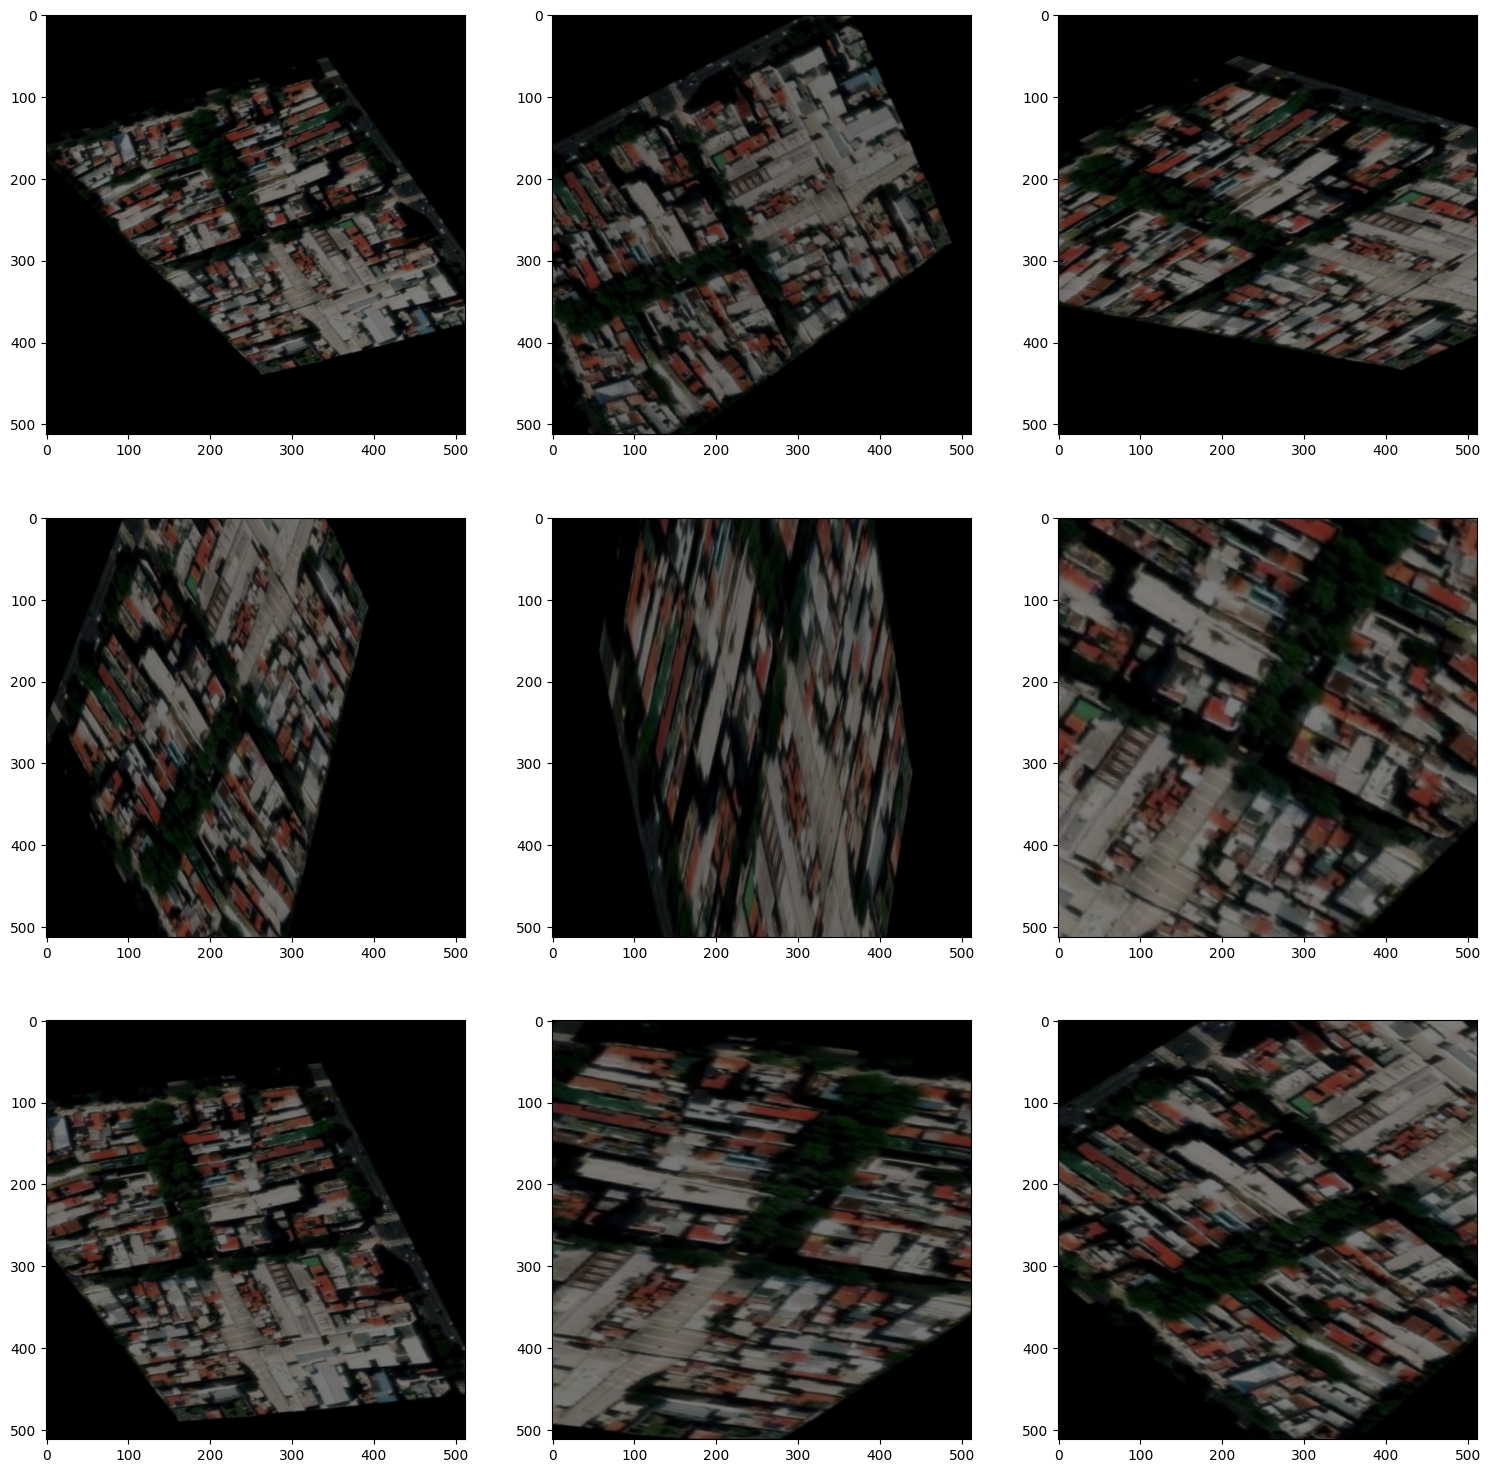

Found 700 validated image filenames.
Found 200 validated image filenames.
Found 100 validated image filenames.


In [8]:
small_sample=True

df = pd.read_parquet(f"{path_dataout}/dataset_indicadores_rc_con_img.parquet")
df['image'] = (f'{path_dataout}/processed_images/' +  df['image'].str.split('\\').str[-1])

if small_sample == True:
    df = df.iloc[0:1000]  # set small_sampe to True if you want to check if your code works without long waiting

train, val, test = split_data(df)  # split your data
mean_baseline = get_mean_baseline(train, val)
train_generator, validation_generator, test_generator = create_generators(
    df=df, train=train, val=val, test=test, plot_augmentations=True
)

In [9]:
# Run Model
small_cnn_history = run_model(
    model_name="small_cnn",
    model_function=small_cnn(),
    lr=0.001,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

eff_net_history = run_model(
    model_name="eff_net",
    model_function=adapt_efficient_net(),
    lr=0.5,
    train_generator=train_generator,
    validation_generator=validation_generator,
    test_generator=test_generator,
)

plot_results(small_cnn_history, eff_net_history, mean_baseline)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 984064)            0

2023-01-25 16:10:21.980083: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-01-25 16:10:21.980146: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-01-25 16:10:21.980193: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-01-25 16:10:21.994097: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:192] cuptiSubscribe: error 15: CUPTI_ERROR_NOT_INITIALIZED
2023-01-25 16:10:21.994158: E tensorflow/core/profiler/backends/gpu/cupti_error_manager.cc:457] cuptiGetResultString: ignored due to a previous error.
2023-01-25 16:10:21.994168: E tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1715] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2023-01-25 16:10:21.994275: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-01-25 16:10:21.994311: E tensorflow/core/profi

Epoch 1/100


2023-01-25 16:10:27.932784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-25 16:10:28.340463: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 16:10:28.411813: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 16:10:28.411884: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-25 16:10:28.472210: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 16:10:28.472363: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5084/2400551077.py", line 2, in <module>
      small_cnn_history = run_model(
    File "/tmp/ipykernel_5084/1820884199.py", line 134, in run_model
      history = model.fit(
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/oficina825/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 5537792 values, but the requested shape requires a multiple of 984064
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_train_function_2972]

In [ ]:
!rm -rf ~/.cache/pip/*